###  MicroGrad demo

In [109]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

In [110]:
np.random.seed(1337)
random.seed(1337)

In [111]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [112]:
# Загрузка данных MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
X_train = X_train.astype('float64') / 255.0 * 2 - 1
X_test = X_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# One-hot кодирование меток
# y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

# y_train_oh

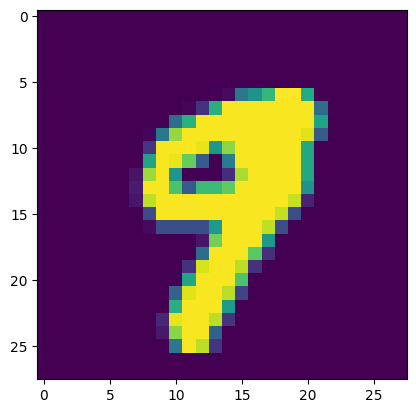

In [113]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(X_train)

In [114]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def oh_encode(y, classes):
    NEG = -1.0
    GREY = 0.0
    POS = 1.0

    noise = np.array([GREY] * len(classes))

    oh_enc = defaultdict(lambda: noise)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = np.array([NEG] * len(classes))
        cls_vec[i] = POS
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    def oh_decode(values):
        # pick the closest vector (is round() OK for that?)
        encoded = tuple(np.array([v.data for v in values]).round())
        return oh_dec[encoded]

    return oh_decode, np.array([oh_enc[cls] for cls in y])

OH_DECODER, Y_oh = oh_encode(Y_train, POSITIVE_CLASSES)
_, Y_t_oh = oh_encode(Y_test, POSITIVE_CLASSES)

Y_oh.shape

(60000, 10)

In [115]:
def get_batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]
    return X, Y_oh


def arr2vals(array, name):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))

In [116]:
def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += OH_DECODER(score) == OH_DECODER(ground_truths)

    return matches / len(scores)


def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def loss(scores, Y_oh):
    return sum(one_loss(xs, ys) for xs, ys in zip(scores, Y_oh))


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X_b, Y_b):
    input = arr2vals(X_b, 'input')
    scores = feed_forward(model, input)
    expected = arr2vals(Y_b, 'expected')
    return loss(scores, expected), accuracy(scores, expected)

In [117]:
# initialize a model
model = MLP(
    784,
    [
        (10, 'xspace')
    ],
    lr=1.0
)
print(model)
print("number of parameters", len(model.parameters()))

X_all, Y_all = None, None

MLP of [Layer of [xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784)]]
number of parameters 7850


In [118]:
# train the model
BATCH_SIZE = 128
X_b, Y_b = get_batch(X_train, Y_oh, BATCH_SIZE)
X_b.shape

if X_all is None:
    assert Y_all is None
    X_all = X_b
    Y_all = Y_b
else:
    assert Y_all is not None
    X_all = np.concatenate([X_all, X_b])
    Y_all = np.concatenate([Y_all, Y_b])

[OH_DECODER(vs) for vs in arr2vals(Y_b, 'expected')]

[6,
 1,
 0,
 5,
 9,
 1,
 6,
 8,
 6,
 7,
 7,
 0,
 2,
 4,
 0,
 9,
 5,
 4,
 3,
 7,
 1,
 3,
 5,
 3,
 7,
 4,
 3,
 4,
 8,
 0,
 8,
 5,
 0,
 7,
 7,
 5,
 8,
 9,
 4,
 3,
 6,
 5,
 0,
 5,
 5,
 3,
 3,
 1,
 2,
 1,
 7,
 2,
 4,
 2,
 2,
 9,
 0,
 5,
 2,
 0,
 8,
 1,
 6,
 3,
 9,
 4,
 0,
 6,
 9,
 0,
 7,
 0,
 8,
 4,
 2,
 5,
 4,
 8,
 9,
 5,
 2,
 6,
 4,
 7,
 4,
 7,
 9,
 5,
 5,
 8,
 9,
 2,
 7,
 4,
 7,
 5,
 7,
 1,
 4,
 9,
 3,
 8,
 4,
 6,
 6,
 6,
 1,
 5,
 5,
 1,
 2,
 4,
 1,
 3,
 9,
 5,
 7,
 8,
 9,
 1,
 8,
 7,
 7,
 2,
 3,
 6,
 4,
 7]

In [119]:
ITERATIONS = 100

# optimization loop
for k in range(ITERATIONS):
    total_loss, acc = evaluate(model, X_b, Y_b)
    print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")
    if total_loss.data == 0:
        print("Early stop!")
        break

    model.learn_from(total_loss)

total_loss, acc = evaluate(model, X_all, Y_all)
print(f"final loss {total_loss.data}, total accuracy {acc*100}%")

step 0: loss 2528.0, accuracy 0.0%
step 1: loss 1312.0, accuracy 0.0%
step 2: loss 1312.0, accuracy 0.0%
step 3: loss 1312.0, accuracy 0.0%
step 4: loss 856.0, accuracy 12.5%
step 5: loss 872.0, accuracy 13.28125%
step 6: loss 844.0, accuracy 13.28125%
step 7: loss 844.0, accuracy 13.28125%
step 8: loss 844.0, accuracy 13.28125%
step 9: loss 844.0, accuracy 13.28125%
step 10: loss 844.0, accuracy 13.28125%
step 11: loss 844.0, accuracy 13.28125%
step 12: loss 844.0, accuracy 13.28125%
step 13: loss 844.0, accuracy 13.28125%
step 14: loss 836.0, accuracy 13.28125%
step 15: loss 468.0, accuracy 8.59375%
step 16: loss 468.0, accuracy 8.59375%
step 17: loss 820.0, accuracy 13.28125%
step 18: loss 884.0, accuracy 9.375%
step 19: loss 1732.0, accuracy 0.0%
step 20: loss 1304.0, accuracy 0.0%
step 21: loss 1236.0, accuracy 0.0%
step 22: loss 988.0, accuracy 4.6875%
step 23: loss 1356.0, accuracy 0.0%


# DEBUG

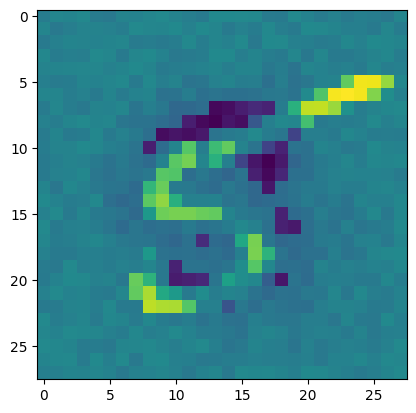

In [108]:
NEURON = 5
w = np.array([p.data for p in model.layers[0].neurons[NEURON].parameters()][:-1])
w = w.reshape([-1, w.shape[0]])
draw_some(w)

In [38]:
# X_t, Y_t = get_batch(X_test, Y_t_oh, BATCH_SIZE)
X_t, Y_t = X_all, Y_all

input = arr2vals(X_t, 'input')
expected = arr2vals(Y_t, 'expected')
scores = feed_forward(model, input)

for a, e in zip(scores, expected):
    a, e = OH_DECODER(a), OH_DECODER(e)
    op = '=' if a == e else '!='
    print(f'actual: {a} {op} expected: {e}')

actual: 6 = expected: 6
actual: 1 = expected: 1
actual: 0 = expected: 0
actual: 5 = expected: 5
actual: 9 = expected: 9
actual: 1 = expected: 1
actual: 6 = expected: 6
actual: 8 = expected: 8
actual: 6 = expected: 6
actual: 7 = expected: 7
actual: 7 = expected: 7
actual: 0 = expected: 0
actual: 2 = expected: 2
actual: 4 = expected: 4
actual: 0 = expected: 0
actual: 9 = expected: 9


In [24]:
scores

[[Value(auto : [5.551115123125783e-17, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [1.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0])],
 [Value(auto : [0.0, 0.0]),
  Value(auto : [1.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0])],
 [Value(auto : [1.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0])],
 [Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),
  Value(auto : [0.0, 0.0]),

In [25]:
expected

[[Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [1.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0])],
 [Value(expected : [0.0, 0.0]),
  Value(expected : [1.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0])],
 [Value(expected : [1.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0]),
  Value(expected : [0.0, 0.0])],
 [Value(expected : [0.0, 0.0]),
  Val

In [26]:
total_loss = loss(scores, expected)
total_loss.backward()
total_loss, [p for p in model.parameters() if p.grad > 0.0]

(Value(auto : [3.0814879110195774e-33, 1]),
 [Value(weight : [-1.061745588431231, 4.506199072572868e-20]),
  Value(weight : [-2.498313157152215, 1.4731804660334376e-19]),
  Value(weight : [-3.605134574377434, 2.201104931602901e-19]),
  Value(weight : [-2.289335105189539, 1.5858354428477595e-19]),
  Value(weight : [-1.8967024564813801, 1.343193954324605e-19]),
  Value(weight : [-0.9247387470610369, 3.2929916299570957e-20]),
  Value(weight : [-0.4397107175421182, 9.359028843035956e-20]),
  Value(weight : [-2.558525486534379, 2.0797841873413238e-19]),
  Value(weight : [-1.9346939088758695, 2.1924391641556457e-19]),
  Value(weight : [-3.105657292974879, 2.1924391641556457e-19]),
  Value(weight : [-2.618739891478101, 2.1924391641556457e-19]),
  Value(weight : [-3.314805422519658, 2.1924391641556457e-19]),
  Value(weight : [-0.41368099841123596, 6.932613957804413e-20]),
  Value(weight : [-0.3453313098652129, 4.332883723627758e-21]),
  Value(weight : [-1.4080809684362618, 8.145821400420186e-2